In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/dataset/AnimalLabelling.zip -d /content/Animal/

Archive:  /content/drive/MyDrive/dataset/AnimalLabelling.zip
 extracting: /content/Animal/README.dataset.txt  
 extracting: /content/Animal/README.roboflow.txt  
   creating: /content/Animal/train/
 extracting: /content/Animal/train/0006476c7a10ac38_jpg.rf.09a597d054490e86e106812ab200e2ca.jpg  
 extracting: /content/Animal/train/0006476c7a10ac38_jpg.rf.4c8e92fba0ae880f002c85e53304861f.jpg  
 extracting: /content/Animal/train/0006476c7a10ac38_jpg.rf.b85ba4af977ab9c360822567b96b8a52.jpg  
 extracting: /content/Animal/train/0011a9e33cde56fc_jpg.rf.1da47e9d317a87fa11e4aa24af55b200.jpg  
 extracting: /content/Animal/train/0011a9e33cde56fc_jpg.rf.1de4d29ab4243e1b29bd5bc2a83728ad.jpg  
 extracting: /content/Animal/train/0011a9e33cde56fc_jpg.rf.3baa3a3825d16f424f522abe706d1fdf.jpg  
 extracting: /content/Animal/train/0044547733c13689_jpg.rf.3c8929fd37d40161d21aa18821d7c5c7.jpg  
 extracting: /content/Animal/train/0044547733c13689_jpg.rf.4b6110c54a95a5565a5598953cecaf14.jpg  
 extracting: /cont

In [ ]:
!pip install -U torchvision # We need a new versino of torchvision for this project

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


Albumentations is used as data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/Animal"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'Animals', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Giraffe', 'supercategory': 'Animals'},
 2: {'id': 2, 'name': 'Goat', 'supercategory': 'Animals'},
 3: {'id': 3, 'name': 'Horse', 'supercategory': 'Animals'},
 4: {'id': 4, 'name': 'Monkey', 'supercategory': 'Animals'},
 5: {'id': 5, 'name': 'o', 'supercategory': 'Animals'}}

This code just gets a list of classes

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Animals', 'Giraffe', 'Goat', 'Horse', 'Monkey', 'o']

In [ ]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

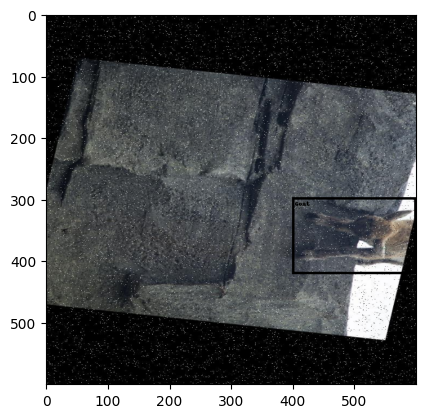

In [ ]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

2435

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
num_epochs=40

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 609/609 [01:38<00:00,  6.16it/s]


Epoch 0, lr: 0.010000, loss: 0.728342, loss_classifier: 0.362593, loss_box: 0.302871, loss_rpn_box: 0.036238, loss_object: 0.026641


100%|██████████| 609/609 [01:40<00:00,  6.07it/s]


Epoch 1, lr: 0.010000, loss: 0.722372, loss_classifier: 0.357691, loss_box: 0.315732, loss_rpn_box: 0.031301, loss_object: 0.017647


100%|██████████| 609/609 [01:35<00:00,  6.34it/s]


Epoch 2, lr: 0.010000, loss: 0.717127, loss_classifier: 0.343719, loss_box: 0.328651, loss_rpn_box: 0.029109, loss_object: 0.015648


100%|██████████| 609/609 [01:34<00:00,  6.44it/s]


Epoch 3, lr: 0.010000, loss: 0.700956, loss_classifier: 0.326308, loss_box: 0.332613, loss_rpn_box: 0.028443, loss_object: 0.013592


100%|██████████| 609/609 [01:34<00:00,  6.44it/s]


Epoch 4, lr: 0.010000, loss: 0.703960, loss_classifier: 0.324382, loss_box: 0.340173, loss_rpn_box: 0.027141, loss_object: 0.012264


100%|██████████| 609/609 [01:34<00:00,  6.45it/s]


Epoch 5, lr: 0.010000, loss: 0.676815, loss_classifier: 0.305234, loss_box: 0.332896, loss_rpn_box: 0.026843, loss_object: 0.011843


100%|██████████| 609/609 [01:32<00:00,  6.58it/s]


Epoch 6, lr: 0.010000, loss: 0.694520, loss_classifier: 0.306212, loss_box: 0.350570, loss_rpn_box: 0.026135, loss_object: 0.011604


100%|██████████| 609/609 [01:33<00:00,  6.55it/s]


Epoch 7, lr: 0.010000, loss: 0.699763, loss_classifier: 0.301105, loss_box: 0.362522, loss_rpn_box: 0.025859, loss_object: 0.010276


100%|██████████| 609/609 [01:32<00:00,  6.60it/s]


Epoch 8, lr: 0.010000, loss: 0.712808, loss_classifier: 0.305549, loss_box: 0.371403, loss_rpn_box: 0.025880, loss_object: 0.009976


100%|██████████| 609/609 [01:31<00:00,  6.67it/s]


Epoch 9, lr: 0.010000, loss: 0.703033, loss_classifier: 0.296169, loss_box: 0.372265, loss_rpn_box: 0.025203, loss_object: 0.009396


100%|██████████| 609/609 [01:31<00:00,  6.64it/s]


Epoch 10, lr: 0.010000, loss: 0.694015, loss_classifier: 0.286858, loss_box: 0.371896, loss_rpn_box: 0.025440, loss_object: 0.009822


100%|██████████| 609/609 [01:32<00:00,  6.57it/s]


Epoch 11, lr: 0.010000, loss: 0.697556, loss_classifier: 0.288569, loss_box: 0.374756, loss_rpn_box: 0.025173, loss_object: 0.009059


100%|██████████| 609/609 [01:32<00:00,  6.60it/s]


Epoch 12, lr: 0.010000, loss: 0.690958, loss_classifier: 0.286963, loss_box: 0.370694, loss_rpn_box: 0.024726, loss_object: 0.008576


100%|██████████| 609/609 [01:31<00:00,  6.69it/s]


Epoch 13, lr: 0.010000, loss: 0.669837, loss_classifier: 0.269412, loss_box: 0.368167, loss_rpn_box: 0.023695, loss_object: 0.008563


100%|██████████| 609/609 [01:31<00:00,  6.68it/s]


Epoch 14, lr: 0.010000, loss: 0.658383, loss_classifier: 0.259881, loss_box: 0.366869, loss_rpn_box: 0.023781, loss_object: 0.007852


100%|██████████| 609/609 [01:30<00:00,  6.71it/s]


Epoch 15, lr: 0.010000, loss: 0.652673, loss_classifier: 0.259524, loss_box: 0.361314, loss_rpn_box: 0.023511, loss_object: 0.008324


100%|██████████| 609/609 [01:30<00:00,  6.72it/s]


Epoch 16, lr: 0.010000, loss: 0.650633, loss_classifier: 0.259742, loss_box: 0.359739, loss_rpn_box: 0.023210, loss_object: 0.007942


100%|██████████| 609/609 [01:31<00:00,  6.64it/s]


Epoch 17, lr: 0.010000, loss: 0.620880, loss_classifier: 0.243299, loss_box: 0.346965, loss_rpn_box: 0.022986, loss_object: 0.007629


100%|██████████| 609/609 [01:30<00:00,  6.72it/s]


Epoch 18, lr: 0.010000, loss: 0.655226, loss_classifier: 0.255905, loss_box: 0.366191, loss_rpn_box: 0.023496, loss_object: 0.009634


100%|██████████| 609/609 [01:30<00:00,  6.75it/s]


Epoch 19, lr: 0.010000, loss: 0.658378, loss_classifier: 0.259712, loss_box: 0.368097, loss_rpn_box: 0.022837, loss_object: 0.007732


100%|██████████| 609/609 [01:30<00:00,  6.75it/s]


Epoch 20, lr: 0.010000, loss: 0.637360, loss_classifier: 0.247497, loss_box: 0.360946, loss_rpn_box: 0.022311, loss_object: 0.006605


100%|██████████| 609/609 [01:29<00:00,  6.80it/s]


Epoch 21, lr: 0.010000, loss: 0.652280, loss_classifier: 0.249213, loss_box: 0.374263, loss_rpn_box: 0.022225, loss_object: 0.006579


100%|██████████| 609/609 [01:27<00:00,  6.94it/s]


Epoch 22, lr: 0.010000, loss: 0.619920, loss_classifier: 0.231716, loss_box: 0.357947, loss_rpn_box: 0.022042, loss_object: 0.008215


100%|██████████| 609/609 [01:26<00:00,  7.05it/s]


Epoch 23, lr: 0.010000, loss: 0.641378, loss_classifier: 0.249836, loss_box: 0.363286, loss_rpn_box: 0.021706, loss_object: 0.006550


100%|██████████| 609/609 [01:27<00:00,  6.99it/s]


Epoch 24, lr: 0.010000, loss: 0.610486, loss_classifier: 0.226009, loss_box: 0.357561, loss_rpn_box: 0.020986, loss_object: 0.005929


100%|██████████| 609/609 [01:29<00:00,  6.80it/s]


Epoch 25, lr: 0.010000, loss: 0.608567, loss_classifier: 0.230767, loss_box: 0.349666, loss_rpn_box: 0.021383, loss_object: 0.006751


100%|██████████| 609/609 [01:29<00:00,  6.77it/s]


Epoch 26, lr: 0.010000, loss: 0.593623, loss_classifier: 0.223615, loss_box: 0.342906, loss_rpn_box: 0.021176, loss_object: 0.005926


100%|██████████| 609/609 [01:29<00:00,  6.84it/s]


Epoch 27, lr: 0.010000, loss: 0.596021, loss_classifier: 0.225190, loss_box: 0.345168, loss_rpn_box: 0.020202, loss_object: 0.005461


100%|██████████| 609/609 [01:28<00:00,  6.91it/s]


Epoch 28, lr: 0.010000, loss: 0.606073, loss_classifier: 0.224244, loss_box: 0.355035, loss_rpn_box: 0.020565, loss_object: 0.006229


100%|██████████| 609/609 [01:27<00:00,  6.93it/s]


Epoch 29, lr: 0.010000, loss: 0.606143, loss_classifier: 0.223388, loss_box: 0.358249, loss_rpn_box: 0.019622, loss_object: 0.004885


100%|██████████| 609/609 [01:27<00:00,  6.99it/s]


Epoch 30, lr: 0.010000, loss: 0.562167, loss_classifier: 0.199487, loss_box: 0.337827, loss_rpn_box: 0.019471, loss_object: 0.005383


100%|██████████| 609/609 [01:30<00:00,  6.71it/s]


Epoch 31, lr: 0.010000, loss: 0.600751, loss_classifier: 0.228612, loss_box: 0.345593, loss_rpn_box: 0.020446, loss_object: 0.006099


100%|██████████| 609/609 [01:30<00:00,  6.75it/s]


Epoch 32, lr: 0.010000, loss: 0.604717, loss_classifier: 0.233784, loss_box: 0.344524, loss_rpn_box: 0.020722, loss_object: 0.005687


100%|██████████| 609/609 [01:30<00:00,  6.76it/s]


Epoch 33, lr: 0.010000, loss: 0.603421, loss_classifier: 0.226862, loss_box: 0.350996, loss_rpn_box: 0.020152, loss_object: 0.005411


100%|██████████| 609/609 [01:29<00:00,  6.81it/s]


Epoch 34, lr: 0.010000, loss: 0.582920, loss_classifier: 0.210532, loss_box: 0.348717, loss_rpn_box: 0.019182, loss_object: 0.004490


100%|██████████| 609/609 [01:30<00:00,  6.75it/s]


Epoch 35, lr: 0.010000, loss: 0.545758, loss_classifier: 0.192613, loss_box: 0.329461, loss_rpn_box: 0.019025, loss_object: 0.004659


100%|██████████| 609/609 [01:29<00:00,  6.81it/s]


Epoch 36, lr: 0.010000, loss: 0.538964, loss_classifier: 0.182390, loss_box: 0.334165, loss_rpn_box: 0.018100, loss_object: 0.004309


100%|██████████| 609/609 [01:29<00:00,  6.84it/s]


Epoch 37, lr: 0.010000, loss: 0.534405, loss_classifier: 0.183453, loss_box: 0.328977, loss_rpn_box: 0.018116, loss_object: 0.003859


100%|██████████| 609/609 [01:29<00:00,  6.81it/s]


Epoch 38, lr: 0.010000, loss: 0.542978, loss_classifier: 0.201245, loss_box: 0.317163, loss_rpn_box: 0.019472, loss_object: 0.005097


100%|██████████| 609/609 [01:29<00:00,  6.80it/s]

Epoch 39, lr: 0.010000, loss: 0.558400, loss_classifier: 0.209146, loss_box: 0.325343, loss_rpn_box: 0.019098, loss_object: 0.004813


## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [ ]:
torch.save(model, '/content/animal_detection_faster_rcnn.h5')

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = AquariumDetection(root=dataset_path, split="train", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
test_dataset

Dataset AquariumDetection
    Number of datapoints: 2435
    Root location: /content/Animal
    Compose([
  Resize(always_apply=False, p=1, height=600, width=600, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [ ]:
import torch
import torchvision.transforms as transforms

# Load image file
img = Image.open("/content/0b1a80bc8a9d9f9a.jpg")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transformations and convert to tensor
img_tensor = transform(img)

img_int = torch.tensor(img_tensor*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img_tensor.to(device)])
    pred = prediction[0]

In [ ]:
prediction

[{'boxes': tensor([[ 93.6163,  44.1023, 175.8876, 170.0204],
          [ 31.1896,  54.6791,  78.0124, 162.4732]], device='cuda:0'),
  'labels': tensor([2, 2], device='cuda:0'),
  'scores': tensor([0.9978, 0.9757], device='cuda:0')}]

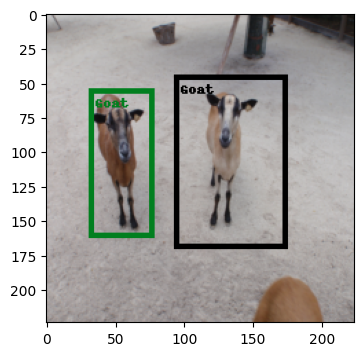

In [ ]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.3],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.3].tolist()], width=4
).permute(1, 2, 0))